In [2]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## setup

In [3]:
#get GEFS members, 6h precip data

dat_dir = '/scratch2/STI/mdl-sti/Sidney.Lower/test_data/gefs/20210601/'
gefs_paths = sorted(glob(dat_dir+'gefs*.t12z.f006'))
filters = dict(productDefinitionTemplateNumber=11)
gefs_data = xr.open_mfdataset(gefs_paths[1::2], chunks=None,engine='grib2io', filters=filters, 
                              parallel=False, concat_dim=[pd.Index(np.arange(len(gefs_paths)/2), name="member")],combine="nested")


In [4]:
from scipy.interpolate import griddata

#objective function
def get_j(ck_arr, b_ik, mean, ens_mem, obs_error, S_grid,S_spec,grid_points, m_k, n_k):
    c_k = {"x": ck_arr[:np.shape(b_ik)[1]], "y": ck_arr[np.shape(b_ik)[1]:]}
    x,y=grid_points
    j_r = residual_error(c_k, b_ik, mean,ens_mem,obs_error,x,y)
    j_a = barrier_func_gp(c_k, b_ik, S_grid)
    j_d = smoothness_func_spec(c_k, m_k, n_k, S_spec)
    j_div = divergence_func_gp(c_k, b_ik)
    j_m = magnitude_func_spec(c_k, S_spec)
    """
    
    the weights for the smoothness and magnitude constraints were rescaled to take 
    into account the difference in the way these penalty functions are computed: 
    The smoothness constraint is computed in spectral space 201 (with 60 degrees of freedom, 
    i.e. contributing terms to the penalty function), while the divergence 202 constraint is 
    summed over each grid point (100,794 in our case). Accordingly, 𝜆𝑝 was set to the 203 
    ratio of the number of terms (1680) for the smoothness and magnitude constraints.
    
    """
    lambda_spec = np.shape(mean)[0]**2 / len(m_k)

    return np.log10(j_r + j_a + lambda_spec*j_d + lambda_spec*j_m + j_div)

def evaluate_at_new_grid(n_x_i, n_y_i, gefs_x, gefs_y, ens_mem):
    #gefs_grid
    gx, gy=np.meshgrid(gefs_x,gefs_y ,indexing='ij')
    
    #coalesced grid
    cx, cy = np.broadcast_arrays(n_x_i[:, None], n_y_i[None, :])
    
    #interpolate ensemble member between displaced grid and gefs grid
    displaced_ens_at_gefs = griddata((cx.ravel(), cy.ravel()), ens_mem.T.ravel(), (gx.ravel(), gy.ravel()), method="nearest")
    
    aligned_ens = np.zeros_like(ens_mem)
    # griddata returns a list of points instead of the 2D field. just need to rearrange below
    for i in range(len(cx)):
        for j in range(len(cy)):
            point = len(cy)*i+j
            aligned_ens[j, i] = displaced_ens_at_gefs[point]
    return aligned_ens

def residual_error(c_k,b_ik,ens_mean, ens_mem, obs_error, x,y):

    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    n_x_i = x + c_xi
    n_y_i = y + c_yi

    displaced_ens = evaluate_at_new_grid(n_x_i, n_y_i, x, y, ens_mem)
    
    before_sum = (ens_mean - displaced_ens)**2
    return np.sum(before_sum / obs_error**2)

def barrier_func_gp(c_k, b_ik,S_grid): #Ja
    #get displacements in grid space
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    return np.sum((c_xi / S_grid)**20 +  (c_yi / S_grid)**20)

def smoothness_func_spec(c_k, m_k, n_k, S_spec): #Jd
    nu_k = (m_k**2 + n_k**2)**(2)

    w_k={'x': (1. / S_spec**2) * nu_k,
            'y': (1. / S_spec**2) * nu_k}
    return np.sum(w_k['x'] * c_k['x']**2 + w_k['y'] * c_k['y']**2)

def divergence(field):
    "return the divergence of a n-D field"
    return np.sum(np.gradient(field),axis=0)

def divergence_func_gp(c_k, b_ik):

    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    nx, ny = len(c_xi), len(c_yi)

    dx = divergence(c_xi)
    dy = divergence(c_yi)
    return (dx+dy)**2

def magnitude_func_spec(c_k, S_spec):
    return np.sum((c_k['x']/S_spec)**2 + (c_k['y']/S_spec)**2)

In [5]:
def basis_functions(target_x, target_y, m_k=None, n_k=None, xrange=(np.nan, np.nan), yrange=(np.nan, np.nan)):

    x = grid2fourier(target_x, xrange)
    y = grid2fourier(target_y, yrange)

    b_ik = np.zeros((len(x), len(m_k)))

    for k in range(len(m_k)):
        b_ik[:, k] = 2 * np.sin(m_k[k] * x) * np.sin(n_k[k] * y)

    return b_ik

def grid2fourier(x, xrange):
    return (np.pi / np.diff(xrange)) * (x - xrange[0])

def basis_truncation(n=3):
    m_k = np.repeat(np.arange(1, n + 1), n)
    n_k = np.repeat(np.arange(1, n + 1), np.repeat(n, n))
    select = m_k**2 + n_k**2 <= n**2

    return m_k[select], n_k[select]

# Testing interpolators

## regular grid interpolator

In [13]:
import scipy.interpolate

ens_mean = gefs_data.APCP.mean(dim='member')
raw_mean = ens_mean.data.compute()
ens_members = gefs_data.APCP.data.compute()
ens_std = gefs_data.APCP.std(dim='member').data.compute()

min_lon = 240 
max_lon = 601
min_lat = 0
max_lat = 361

mem=20
ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon]

m_k, n_k = basis_truncation(7)
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])
d_o_f = len(m_k)

In [25]:
disp = [0.1, 1.]

#gefs grid
gx, gy=np.meshgrid(x,y ,indexing='ij')
gefs_grid_points = np.reshape((gx, gy), (2, -1), order='C').T

for value in disp:
    print(f'running with dx=dy={value}')
    start = datetime.datetime.now()
    #coalesced grid
    c_k = {"x": np.repeat(value, d_o_f), "y": np.repeat(value, d_o_f)}
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    n_x_i = x + c_xi
    n_y_i = y + c_yi
    
    #ensemble member at new grid points
    try:
        interp = scipy.interpolate.RegularGridInterpolator((n_x_i,n_y_i), ens_mem.T,bounds_error=False, fill_value=None)
    except:
        print('    regular grid only works if displacements are smaller than grid spacing')
        continue
    
    #get values at GEFS grid points, to compare with ensemble mean
    displaced_precip = interp(gefs_grid_points)
    
    finish = datetime.datetime.now()
    print(f'    succesfully finished in {(finish-start).total_seconds()} s')
    #print(finish - start)

running with dx=dy=0.1
    succesfully finished in 0.014208 s
running with dx=dy=1.0
    regular grid only works if displacements are smaller than grid spacing


Fast, but only works if displacements are smaller than grid spacing (because grid is not longer rectilinear). This also happens with [scipy.interpolate.RectBivariateSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html#scipy.interpolate.RectBivariateSpline) and [scipy.interpolate.interpn](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interpn.html#scipy.interpolate.interpn) which wraps the RegularGridInterpolate function.

## griddata

In [24]:
disp = [0.1, 1.]

#gefs grid
gx, gy=np.meshgrid(x,y ,indexing='ij')
gefs_grid_points = np.reshape((gx, gy), (2, -1), order='C').T

for value in disp:
    for method in ['cubic', 'linear', 'nearest']:
        print(f'running with dx=dy={value} and method={method}')
        start = datetime.datetime.now()
        #coalesced grid
        c_k = {"x": np.repeat(value, d_o_f), "y": np.repeat(value, d_o_f)}
        c_xi = np.dot(b_ik, c_k['x'])
        c_yi = np.dot(b_ik, c_k['y'])
        n_x_i = x + c_xi
        n_y_i = y + c_yi
        xg, yg = np.broadcast_arrays(n_x_i[:, None], n_y_i[None, :])
    
        displaced_ens = scipy.interpolate.griddata((xg.ravel(), yg.ravel()), ens_mem.T.ravel(), (gx.ravel(), gy.ravel()), method=method)
    
        finish = datetime.datetime.now()
        print(f'    succesfully finished in {(finish-start).total_seconds()} s')

running with dx=dy=0.1 and method=cubic
    succesfully finished in 2.949332 s
running with dx=dy=0.1 and method=linear
    succesfully finished in 2.111316 s
running with dx=dy=0.1 and method=nearest
    succesfully finished in 0.134456 s
running with dx=dy=1.0 and method=cubic
    succesfully finished in 2.281267 s
running with dx=dy=1.0 and method=linear
    succesfully finished in 2.262369 s
running with dx=dy=1.0 and method=nearest
    succesfully finished in 0.138347 s


Slower to much slower depending on interpolation method, but can work with larger displacements. Cubic method uses [scipy.interpolate.CloughTocher2DInterpolator](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CloughTocher2DInterpolator.html#scipy.interpolate.CloughTocher2DInterpolator), linear method uses [scipy.interpolate.LinearNDInterpolator](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html#scipy.interpolate.LinearNDInterpolator), and nearest uses [scipy.interpolate.NearestNDInterpolator](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.NearestNDInterpolator.html#scipy.interpolate.NearestNDInterpolator). 

Most of the computation time is spend on the triangulation calculation...unfortunately for our case, this has to happen everytime the interpolation is evaluated since the input (coalesced) grid changes during the minimization run. If the interpolation was done the other way around (GEFS --> coalesced), this triangulation could be pre-computed and done just once per ensemble member (see [stackoverflow: speedup scipy griddata for multiple interpolations between two grids](https://stackoverflow.com/questions/51858194/storing-the-weights-used-by-scipy-griddata-for-re-use/51937990#51937990))

## KDTree

In [26]:
from scipy.spatial import KDTree

In [27]:
disp = [0.1, 1.]

#gefs grid
gx, gy=np.meshgrid(x,y ,indexing='ij')
gefs_grid_points = np.reshape((gx, gy), (2, -1), order='C').T

for value in disp:
    print(f'running with dx=dy={value}')
    start = datetime.datetime.now()
    #coalesced grid
    c_k = {"x": np.repeat(value, d_o_f), "y": np.repeat(value, d_o_f)}
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    n_x_i = x + c_xi
    n_y_i = y + c_yi
    distorted_grid_points = np.reshape((n_x_i, n_y_i), (2, -1), order='C').T
    distorted_tree = KDTree(distorted_grid_points)
    find_values_at_gefs = distorted_tree.query(gefs_grid_points)[1]

    finish = datetime.datetime.now()
    print(f'    succesfully finished in {(finish-start).total_seconds()} s')

running with dx=dy=0.1
    succesfully finished in 0.176837 s
running with dx=dy=1.0
    succesfully finished in 0.165041 s


About the same runtime as the griddata with nearest neighbor interpolation...because that's exactly what it is (just need to massage the output a bit since it returns the indices of the nearest neighbors as a 1D array)

# Testing objective function components

when does each penalty function dominate? scoping out penalty function weights, scalings, truncation, etc.

From Henderson, Hamill, and Nehrkorn:

"Sensitivity experiments with varying values for these parameters were evaluated through inspection of coalesced mean fields and selected ensemble member displacements in order to develop an initial “tuned” set of parameters: 𝑆 = 700𝑘𝑚, 𝑁𝑡𝑟𝑢𝑛𝑐 = 7, 𝜎 = 5𝑚𝑚 for precipitable water, 𝜎 = 1.3𝑚𝑚 for total precipitation, and 𝜆𝑝 = 1 for all terms 𝑝.

For the final configuration applied to the GEFSv12 forecasts, we modified these initial parameters as follows: the weights for the smoothness and magnitude constraints were rescaled to take into account the difference in the way these penalty functions are computed: The smoothness constraint is computed in spectral space (with 60 degrees of freedom, i.e. contributing terms to the penalty function), while the divergence constraint is summed over each grid point (100,794 in our case). Accordingly, 𝜆𝑝 was set to the ratio of the number of terms (1680) for the smoothness and magnitude constraintIn addition, we modified the length scale parameter – which represents the maximum expected displacements used in the FAT algorithm based on forecast length. We derived a scaling factor based on reported error growth of GFS hurricane track errors. The average of values reported in Dong et al. (2020) and Hazelton et al. (2018) is shown in Table 2, along with our derived scaling factor applied to the 96-hr value. Linear interpolation/extrapolation was used to arrive at the value of 𝑆 for each forecast length."

Should the ensemble variance at each point be used? Or a constant value? Maybe the mean...Afterall, these numbers are for the 96h forecast lead time.

#grid points / degrees of freedom for the penalty functions calculated in spectral space make sense. 

The scale (S) is time dependent in the paper; as we are interested in only the 6 hour forecast range, we should adopt the value S = 70 km based on their Table 2, which roughly corresponds to S = 0.7 degrees. Does it make sense to use the same scaling for both the spectral and the grid space? What is 0.7 degree displacement in spectral space?ngth."

In [59]:
#setup displacements
m_k, n_k = basis_truncation(7) #truncating the basis functions B_k to wavenumbers < 7
min_lon = 240 
max_lon = 601
min_lat = 0
max_lat = 361
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
#get displacement basis functions, transforms grid x,y to fourier space
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]]
    )
d_o_f = len(m_k)
#basis function coefficients, the target of our minimization
c_k = {"x": np.repeat(0.02, d_o_f), "y": np.repeat(0., d_o_f)}

#physical displacements
c_xi = np.dot(b_ik, c_k['x'])
c_yi = np.dot(b_ik, c_k['y'])


Want $\sqrt{ \left(b_{ik} \cdot c_{kx})^2 + (b_{ik} \cdot c_{ky}\right)^2} < 0.7$. For simplicity, let's set $c_{ky} = 0$. LOL I am so bad at linear algebra...this can't be done, right? Geometry...

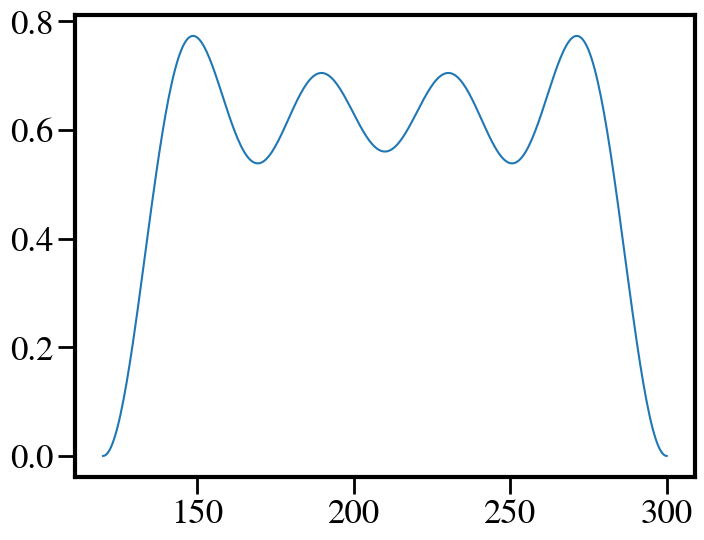

In [60]:
plt.plot(x, c_xi)

In [67]:
def get_j(ck_arr, b_ik, mean, ens_mem,obs_error, S_grid,S_spec,grid_points, m_k, n_k):
    c_k = {"x": ck_arr[:np.shape(b_ik)[1]], "y": ck_arr[np.shape(b_ik)[1]:]}
    x,y=grid_points
    j_r = residual_error(c_k, b_ik, mean,ens_mem,obs_error,x,y)
    j_a = barrier_func_gp(c_k, b_ik, S_grid)
    j_d = smoothness_func_spec(c_k, m_k, n_k, S_spec)
    j_div = divergence_func_gp(c_k, b_ik)
    j_m = magnitude_func_spec(c_k, S_spec)

    lambda_spec = np.shape(mean)[0]**2 / len(m_k)

    print(f'Jr = {j_r:.2e}')
    print(f'Ja = {j_a:.2e}')
    print(f'Jd = {lambda_spec*j_d:.2e}')
    print(f'Jm = {lambda_spec*j_m:.2e}')
    print(f'Jdiv = {j_div:.2e}')
    
    return j_r + j_a + lambda_spec*j_d + lambda_spec*j_m + j_div

#get displacement basis functions, transforms grid x,y to fourier space
m_k, n_k = basis_truncation(7)
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])
d_o_f = len(m_k)
xy_list = np.reshape([x,y],  (2,-1),order='C').T

#set error, scalings
#std = ens_std.copy()[min_lat:max_lat,min_lon:max_lon].T
#r, c = np.where(std == 0.0)
#std[r, c] = 1e-1
#std=0.5
std = np.mean(ens_std)
S_a = 0.7
S_mag = 0.02

mem=10
ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon]

ckx, cky = 0.1,0.1
c_k = {"x": np.repeat(ckx, d_o_f), "y": np.repeat(cky, d_o_f)}
ck_arr = np.ravel(np.array([c_k['x'], c_k['y']])) 
obj = get_j(ck_arr,b_ik, raw_mean[min_lat:max_lat,min_lon:max_lon],ens_mem, 
                                            std, S_a,S_mag,(x,y), m_k, n_k)

Jr = 7.00e+06
Ja = 5.69e+16
Jd = 2.31e+09
Jm = 6.52e+06
Jdiv = 3.16e-30


In [68]:
std

0.35894516

# Testing objective function gradient space

What does the objective func look like at different c_k values?

In [69]:
mem=10
xrange,yrange,num=0.1,0.1,20
m_k, n_k = basis_truncation(7)
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
#get displacement basis functions, transforms grid x,y to fourier space
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])
d_o_f = len(m_k)
xy_list = np.reshape([x,y],  (2,-1),order='C').T

std=np.mean(ens_std)
S_a = 0.7
S_mag = 0.02

jval=np.empty((num,num))
ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon].T
for ckx,xidx in tqdm(zip(np.linspace(xrange*-1, xrange,num), np.arange(num)), total=num):
    for cky,yidx in zip(np.linspace(yrange*-1, yrange,num), np.arange(num)):
        c_k = {"x": np.repeat(ckx, d_o_f), "y": np.repeat(cky, d_o_f)}
        ck_arr = np.ravel(np.array([c_k['x'], c_k['y']])) 
        obj = get_j(ck_arr,b_ik, raw_mean[min_lat:max_lat,min_lon:max_lon],ens_mem, 
                                            std, S_a,S_mag,(x,y), m_k, n_k)
        jval[xidx,yidx] = obj

  0%|          | 0/20 [00:00<?, ?it/s]

Jr = 8.51e+06
Ja = 5.69e+16
Jd = 2.31e+09
Jm = 6.52e+06
Jdiv = 3.16e-30
Jr = 8.56e+06
Ja = 3.15e+16
Jd = 2.08e+09
Jm = 5.87e+06
Jdiv = 7.89e-31
Jr = 8.51e+06
Ja = 2.87e+16
Jd = 1.87e+09
Jm = 5.29e+06
Jdiv = 7.89e-31
Jr = 8.44e+06
Ja = 2.84e+16
Jd = 1.69e+09
Jm = 4.78e+06
Jdiv = 1.23e-30
Jr = 8.39e+06
Ja = 2.84e+16
Jd = 1.54e+09
Jm = 4.35e+06
Jdiv = 7.89e-31
Jr = 8.54e+06
Ja = 2.84e+16
Jd = 1.41e+09
Jm = 3.99e+06
Jdiv = 1.97e-31
Jr = 8.48e+06
Ja = 2.84e+16
Jd = 1.31e+09
Jm = 3.70e+06
Jdiv = 1.23e-30
Jr = 8.48e+06
Ja = 2.84e+16
Jd = 1.23e+09
Jm = 3.48e+06
Jdiv = 7.89e-31
Jr = 8.49e+06
Ja = 2.84e+16
Jd = 1.18e+09
Jm = 3.34e+06
Jdiv = 6.93e-31
Jr = 8.50e+06
Ja = 2.84e+16
Jd = 1.16e+09
Jm = 3.27e+06
Jdiv = 7.89e-31
Jr = 8.50e+06
Ja = 2.84e+16
Jd = 1.16e+09
Jm = 3.27e+06
Jdiv = 7.89e-31
Jr = 8.52e+06
Ja = 2.84e+16
Jd = 1.18e+09
Jm = 3.34e+06
Jdiv = 7.89e-31
Jr = 8.50e+06
Ja = 2.84e+16
Jd = 1.23e+09
Jm = 3.48e+06
Jdiv = 7.89e-31
Jr = 8.48e+06
Ja = 2.84e+16
Jd = 1.31e+09
Jm = 3.70e+06
Jdiv = 4

Text(0, 0.5, '$\\Delta y$')

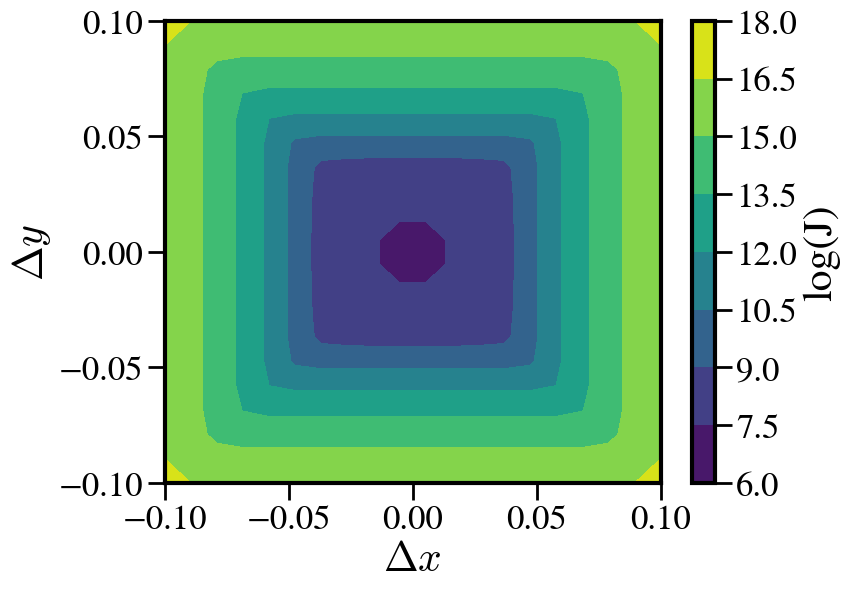

In [70]:
X,Y=np.meshgrid(np.linspace(xrange*-1,xrange,num),np.linspace(yrange*-1, yrange,num))

cs=plt.contourf(X,Y,np.log10(jval))
plt.colorbar(label='log(J)')
plt.xlabel('$\Delta x$')
plt.ylabel('$\Delta y$')
